In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, coo_matrix
from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis, Params

In [4]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [5]:
tree = make_tree([3,3,3])

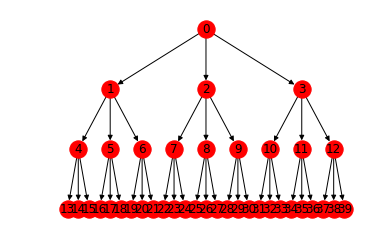

In [6]:
nice_tree_plot(tree)

## Extracting a tree from simulated data

In [8]:
sampler = HPAM2Sampler(tree, num_docs = 1000, words_per_doc = 1000, vocab_size = 1000)

In [9]:
%%time
sampler.sample();

100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]

CPU times: user 1min 50s, sys: 1.34 s, total: 1min 52s
Wall time: 1min 51s


In [10]:
%%time
data = lil_matrix((sampler.num_docs, sampler.vocab_size), dtype='float')
for doc_index, doc in enumerate(tqdm.tqdm(sampler.docs)):
    doc = sorted(doc)
    for vocab_index in doc:
        data[doc_index, vocab_index] += 1
data = csr_matrix(data)

100%|██████████| 1000/1000 [00:10<00:00, 96.46it/s]


CPU times: user 10.3 s, sys: 162 ms, total: 10.5 s
Wall time: 10.5 s


In [11]:
num_digits = len(str(sampler.vocab_size - 1))
vocab = ["w{:0{}d}".format(i, num_digits) for i in range(sampler.vocab_size)]

In [12]:
K = len(tree.nodes())

In [13]:
analysis = Analysis(params = Params(
    infile = data.transpose(),
    vocab_file = vocab,
    outfile = None,
    loss = "L2",
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = 100,
    top_words = 10,
))

In [14]:
%%time
analysis.run();

Input matrix shape: (1000, 1000)
identifying candidate anchors
1000 candidates
Sum of entries in Q is  1.0000000000000004
Multiplying Q took  0.8722050189971924 seconds
Q sum is 1.0000000000000004
done reading documents
anchors are:
0 w912
1 w980
2 w720
3 w183
4 w766
5 w795
6 w453
7 w409
8 w240
9 w628
10 w461
11 w235
12 w483
13 w681
14 w122
15 w649
16 w915
17 w721
18 w719
19 w336
20 w804
21 w778
22 w662
23 w033
24 w990
25 w932
26 w876
27 w849
28 w624
29 w728
30 w076
31 w855
32 w659
33 w645
34 w771
35 w187
36 w129
37 w441
38 w622
39 w665
begin threaded recovery with 8 processors
0	158	0.256317613259205
done recovering
w912 : w912 w963 w976 w216 w928 w740 w365 w108 w911 w967 
w980 : w980 w633 w942 w499 w217 w943 w038 w173 w280 w862 
w720 : w720 w078 w414 w091 w313 w708 w824 w597 w440 w007 
w183 : w183 w910 w093 w215 w816 w403 w776 w082 w475 w437 
w766 : w766 w225 w173 w218 w499 w052 w421 w651 w071 w634 
w795 : w795 w078 w708 w564 w146 w084 w091 w686 w394 w031 
w453 : w453 w078 w708 w190 

In [15]:
analysis.Q.shape

(1000, 1000)

In [16]:
R = analysis.R

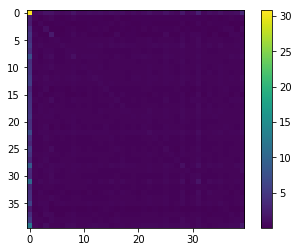

In [17]:
fig, ax = plt.subplots()
ax.imshow(R);
fig.colorbar(ax.get_images()[0]);

In [18]:
np.max(np.abs(R - R.T))

9.182716969145616

In [19]:
R.min(), R.max()

(0.03995634163636324, 30.770769858569267)

In [20]:
R.sum()

965.308200979601

In [30]:
Rprime = 0.5 * R + 0.5 * R.T
Rprime /= Rprime.sum()
C = Aho.get_ratio_matrix(Rprime)

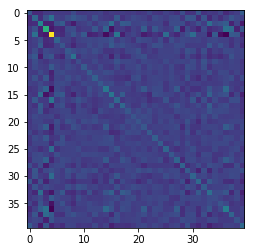

In [31]:
plt.imshow(C);

In [32]:
extracted_tree = Aho.extract(C)

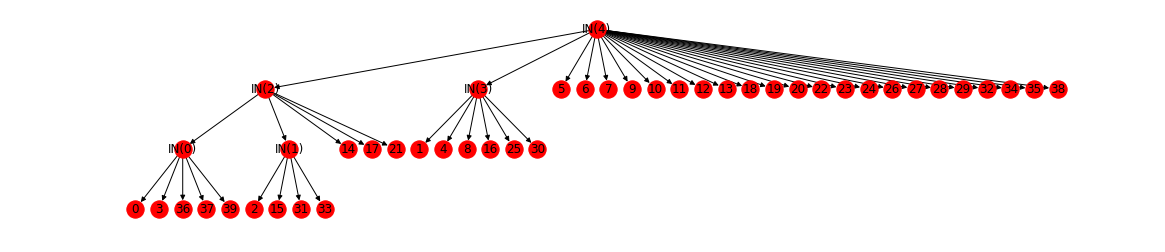

In [33]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

* TODO: extract tree from real data
* TODO: run the tree-building sequence on the above results